In [1]:
from utils.utils import get_config, get_rid2code, shuffle
import os
config = get_config()
gpu = config['train']['gpu']
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from model import HCNet
from tqdm import tqdm
from train import train, test
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier


/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
base_dir = config['base']['base_dir']
batch_size = config['train']['batch_size']
lr = float(config['train']['lr'])
num_epoch = config['train']['epoch']
rate = config['train']['rate']
subject = config['base']['subject']
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


## Data Preprocessing

In [5]:
feature_path = os.path.join(config['base']['base_dir'], 'feature', 'hc_seg')
data_list = os.listdir(feature_path)
# data_list.sort()
X = list()
y = list()
rid2code = get_rid2code(os.path.join(config['base']['data_dir'], 'pd_no_other_health_history.csv'), subject)
chosen_rid = list(rid2code.keys())
for record in data_list:
    if record.split('_')[0] not in chosen_rid:
        continue
    f = np.load(os.path.join(feature_path, record))
    l = rid2code[record.split('_')[0]]
    X.append(f)
    y.append(l)

print(f'Initialize gait data including {len(X)} feature vectors of {len(set(rid2code.values()))} people.')

Initialize gait data including 14188 feature vectors of 10 people.


## Using Neural Network

In [6]:
X = np.array(X)
y = np.array(y)
X, y = shuffle(X, y)
divide = int(len(X)*rate)
train_X, train_y = X[:divide], y[:divide]
test_X, test_y = X[divide+1:], y[divide+1:]
print(f'{len(train_X)} training records, {len(test_X)} testing records.')

11350 training records, 2837 testing records.


In [7]:
train_X = torch.as_tensor(train_X, dtype=torch.float32)
train_y = torch.as_tensor(train_y, dtype=torch.int64)
test_X = torch.as_tensor(test_X, dtype=torch.float32)
test_y = torch.as_tensor(test_y, dtype=torch.int64)
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(len(train_dataloader), len(test_dataloader))

178 45


In [1]:
model = HCNet(in_num=4, out_num=subject)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=5e-4)

train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train(model=model, num_epoch=num_epoch, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=test_dataloader, optimizer=optimizer, device=device)

NameError: name 'HCNet' is not defined

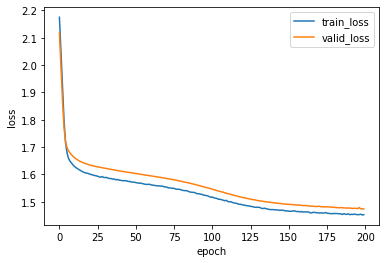

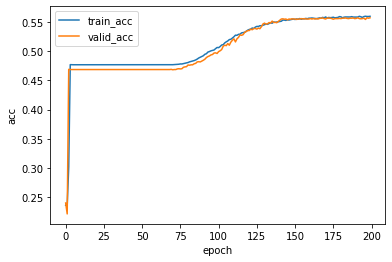

In [9]:
result_dir = os.path.join(base_dir, 'figure')
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

plt.figure()
sns.lineplot(data = train_loss_history, label = 'train_loss')
sns.lineplot(data = valid_loss_history, label = 'valid_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(result_dir, 'loss.png'))

plt.figure()
sns.lineplot(data = train_acc_history, label = 'train_acc')
sns.lineplot(data = valid_acc_history, label = 'valid_acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(result_dir, 'acc.png'))

In [10]:
checkpoint = torch.load('checkpoint/1/best_ckpt.pth')
model.load_state_dict(checkpoint['model'], False)
best_acc = checkpoint['acc']
best_epoch = checkpoint['epoch']
y_pred, y_true = test(model, test_dataloader, criterion, device)
print(metrics.classification_report(y_true, y_pred))

Test loss = 1.47103, acc = 0.55834
              precision    recall  f1-score   support

           0       0.55      0.92      0.69      1329
           1       0.57      0.52      0.55       682
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00       234
           4       0.00      0.00      0.00        66
           5       0.00      0.00      0.00        73
           6       0.00      0.00      0.00        43
           8       0.00      0.00      0.00       264
           9       0.00      0.00      0.00       141

    accuracy                           0.56      2837
   macro avg       0.13      0.16      0.14      2837
weighted avg       0.40      0.56      0.46      2837



/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [11]:
seed = 10
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=rate, random_state=seed)
print(len(train_X), len(test_X))


11350 2838


In [12]:
forest = RandomForestClassifier(n_estimators=100, random_state=seed)
forest.fit(train_X, train_y)
# print("Global accuracy：", forest.score(test_X, test_y))
importances = forest.feature_importances_
print('Importance of each dimension: ', importances)
y_pred = forest.predict(test_X)
print(len(y_pred))
report = metrics.classification_report(test_y, y_pred)
print(report)

Importance of each dimension:  [0.38181204 0.14849511 0.1453513  0.32434154]
2838
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1339
           1       0.59      0.67      0.63       688
           2       0.00      0.00      0.00         5
           3       0.34      0.32      0.33       222
           4       0.17      0.12      0.14        59
           5       0.24      0.07      0.10        76
           6       0.27      0.09      0.13        46
           8       0.24      0.12      0.16       270
           9       0.34      0.29      0.31       133

    accuracy                           0.60      2838
   macro avg       0.32      0.27      0.28      2838
weighted avg       0.56      0.60      0.57      2838



In [13]:
clf = AdaBoostClassifier(n_estimators=10)
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
report = metrics.classification_report(test_y, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.62      0.87      0.73      1339
           1       0.59      0.56      0.57       688
           2       0.00      0.00      0.00         5
           3       0.21      0.19      0.20       222
           4       0.00      0.00      0.00        59
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00        46
           8       0.00      0.00      0.00       270
           9       0.26      0.21      0.23       133

    accuracy                           0.57      2838
   macro avg       0.19      0.20      0.19      2838
weighted avg       0.47      0.57      0.51      2838



/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [14]:

xgbc = XGBClassifier()
xgbc.fit(train_X, train_y)
y_pred = xgbc.predict(test_X)
report = metrics.classification_report(test_y, y_pred)
print(report)


/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1339
           1       0.60      0.70      0.65       688
           2       0.00      0.00      0.00         5
           3       0.35      0.33      0.34       222
           4       0.00      0.00      0.00        59
           5       0.28      0.07      0.11        76
           6       0.38      0.07      0.11        46
           8       0.29      0.12      0.17       270
           9       0.36      0.29      0.32       133

    accuracy                           0.62      2838
   macro avg       0.33      0.27      0.27      2838
weighted avg       0.57      0.62      0.58      2838



In [15]:
clf = DecisionTreeClassifier()
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
report = metrics.classification_report(test_y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1339
           1       0.55      0.53      0.54       688
           2       0.00      0.00      0.00         5
           3       0.29      0.31      0.30       222
           4       0.12      0.15      0.13        59
           5       0.11      0.11      0.11        76
           6       0.24      0.22      0.23        46
           8       0.18      0.18      0.18       270
           9       0.20      0.20      0.20       133

    accuracy                           0.53      2838
   macro avg       0.27      0.27      0.27      2838
weighted avg       0.53      0.53      0.53      2838

